In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fileList(path_before):
    file_list = os.listdir(path_before)
    names = []
    for file in file_list:
        names.append(file)
    names.sort()
    return names


In [20]:
X = []
y = []
Type = []

for type in fileList('MVTec_grid'):
    # if type == 'good':
    #     for name in fileList('MVTec_grid/good'):
    #         good.append(plt.imread('MVTec_grid/good/'+name))

    # else:

    for name in fileList('MVTec_grid/' + type):
        image = plt.imread('MVTec_grid/'+type+'/'+name)
        X.append(cv2.resize(image, (200, 200)))
        y.append(type != 'good')
        Type.append(type)

X = np.array(X)
X = np.expand_dims(X, axis=-1)
y = np.array(y)

In [29]:
# 업샘플링 야매로

X = []
y = []
Type = []

for type in fileList('MVTec_grid'):
    # if type == 'good':
    #     for name in fileList('MVTec_grid/good'):
    #         good.append(plt.imread('MVTec_grid/good/'+name))

    # else:

    for name in fileList('MVTec_grid/' + type):
        image = plt.imread('MVTec_grid/'+type+'/'+name)
        image = cv2.resize(image, (100, 100))
        if type != 'good':
            X.append(image)
            y.append(type != 'good')
            Type.append(type)
        X.append(image)
        y.append(type != 'good')
        Type.append(type)

X = np.array(X)
X = np.expand_dims(X, axis=-1)
y = np.array(y)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=Type)

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(302, 100, 100, 1) (302,)
(76, 100, 100, 1) (76,)


In [35]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

inputs = layers.Input(shape=(100, 100, 1))

# Body
x = layers.Conv2D(64, (5, 5), padding='same', strides=1)(inputs)
x = layers.MaxPooling2D((2,2), strides=2)(x)
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)

x = layers.Conv2D(128, (3, 3), padding='same', strides=1)(x)
x = layers.MaxPooling2D((2,2), strides=2)(x)
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)

x = layers.Conv2D(128, (3, 3), padding='same', strides=1)(x)
x = layers.MaxPooling2D((2,2), strides=2)(x)
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)

# Neck
x = layers.GlobalMaxPooling2D()(x)

# Header
x = layers.Dense(128)(x) # 바로 activation하지말고 아래와 같이 하는 것이 성능 더 좋음
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64)(x) # 바로 activation하지말고 아래와 같이 하는 것이 성능 더 좋음
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64)(x) # 바로 activation하지말고 아래와 같이 하는 것이 성능 더 좋음
x = layers.BatchNormalization()(x)  # 배치정규화
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 100, 100, 64)      1664      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_27 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 50, 50, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 50, 128)       7385

In [36]:
es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=300, callbacks=[es_callback])

Epoch 1/300


2/2 [==============================] - 8s 3s/step - loss: 0.7240 - acc: 0.5685 - val_loss: 0.6841 - val_acc: 0.7541
Epoch 2/300
2/2 [==============================] - 0s 200ms/step - loss: 0.5192 - acc: 0.7137 - val_loss: 0.6760 - val_acc: 0.7541
Epoch 3/300
2/2 [==============================] - 0s 200ms/step - loss: 0.4945 - acc: 0.7593 - val_loss: 0.6693 - val_acc: 0.7541
Epoch 4/300
2/2 [==============================] - 0s 197ms/step - loss: 0.3905 - acc: 0.8714 - val_loss: 0.6652 - val_acc: 0.7541
Epoch 5/300
2/2 [==============================] - 0s 198ms/step - loss: 0.3474 - acc: 0.9004 - val_loss: 0.6571 - val_acc: 0.7541
Epoch 6/300
2/2 [==============================] - 0s 199ms/step - loss: 0.3242 - acc: 0.9004 - val_loss: 0.6483 - val_acc: 0.7541
Epoch 7/300
2/2 [==============================] - 0s 198ms/step - loss: 0.2634 - acc: 0.9253 - val_loss: 0.6384 - val_acc: 0.7541
Epoch 8/300
2/2 [==============================] - 0s 198ms/step - loss: 0.2468 - acc: 0.9502 - va

In [37]:
p_test = model.predict(X_test)
p_test

3/3 [==============================] - 1s 112ms/step


array([[0.24395809],
       [0.24320099],
       [0.24344335],
       [0.24414183],
       [0.24294576],
       [0.24270564],
       [0.24338521],
       [0.24282674],
       [0.24472474],
       [0.24326144],
       [0.2446615 ],
       [0.2445654 ],
       [0.24326968],
       [0.24469772],
       [0.24252811],
       [0.2443559 ],
       [0.24284802],
       [0.2436616 ],
       [0.24266806],
       [0.24302544],
       [0.24456973],
       [0.244257  ],
       [0.242308  ],
       [0.24372435],
       [0.24346766],
       [0.2447891 ],
       [0.24378951],
       [0.24249786],
       [0.24257496],
       [0.24452017],
       [0.24296866],
       [0.24486692],
       [0.24336934],
       [0.24380766],
       [0.24467857],
       [0.24404424],
       [0.24276833],
       [0.24309462],
       [0.24390809],
       [0.24320784],
       [0.24280332],
       [0.24428278],
       [0.24493276],
       [0.24184434],
       [0.24292395],
       [0.24558882],
       [0.24282104],
       [0.244

3/3 [==============================] - 0s 54ms/step
정확도 : 0.6973684210526315
f1 : 0.0


<Figure size 640x480 with 0 Axes>

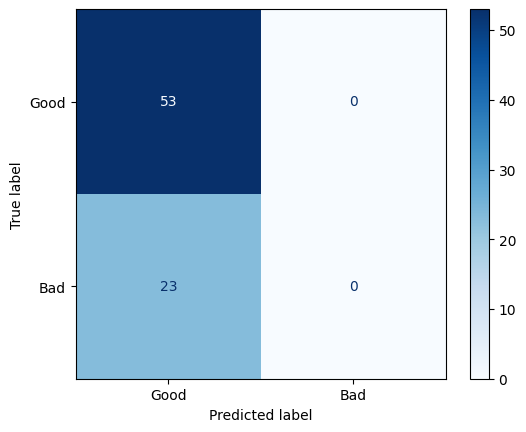

In [38]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

p_test = model.predict(X_test)
p_test_bin = p_test>=0.5

print('정확도 :', accuracy_score(y_test, p_test_bin))
print('f1 :', f1_score(y_test, p_test_bin))

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_test_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()


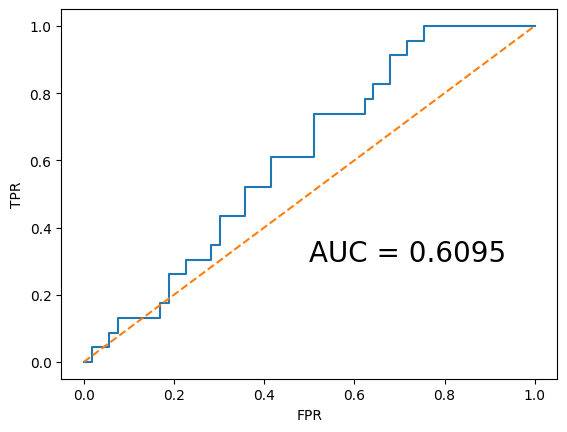

In [39]:
fpr, tpr, _ = roc_curve(y_test, p_test)
auc = roc_auc_score(y_test, p_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.text(0.5, 0.3, f'AUC = {auc:.4f}', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()